# Business Understanding
Recent heeft de gemeente Denver een initiatief gestart om de veiligheid van haar stad te verbeteren door haar keuzes te maken onderbouwd op data. Zij zijn in specifiek geïnteresseerd in hoe de verkeersveiligheid en het politiekorps slimmer en meer efficiënt kan worden ingezet.

In dit verslag gaan wij onderzoeken welke type misdaad er het vaakst voorkomt in een gegeven wijk zodat dit type misdaad gericht aangepakt kan worden. De bijhorende user story staat hieronder weergegeven.

- Als gemeente wil ik per type misdaad zien in welke wijk deze het meest voor komen, zodat dit type misdaden gericht aangepakt kunnen worden.
    - Weergeven in een staafdiagram per type misdaad
    - Uitschieters per type misdaad
    - Het gemiddelde van de misdaden per het aantal inwoners in een wijk.

# Data Understanding
We hebben een dataset gekregen die bestaat uit incidenten van de stad Denver van de afgelopen vijf jaar. De gegevens komen van het National Incident Based Reporting System (NIBRS).

In [35]:
# Importeren van benodigde packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import folium

# Dit zijn wat parameters die de kleuren van plotjes aanpassen. Alleen als je gebruik maakt van PyCharm zijn deze nodig.
mpl.rcParams['text.color'] = "#000"
mpl.rcParams['axes.labelcolor'] = "#fff"
mpl.rcParams['xtick.color'] = "#fff"
mpl.rcParams['ytick.color'] = "#fff"
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['font.size'] = 12

sns.set_style('white')

## Collect initial data
De data is aan ons aangeleverd in de vorm van twee CSV-bestanden. Deze zijn met elkaar gekoppeld aan de hand van de identieke kolomnamen ‘offense_code’. Andere interessante gegevens zijn de datum en plaats waar en wanneer het strafbare feit is gepleegd.

In [36]:
df_crime = pd.read_csv('crime.csv', parse_dates=[
    'FIRST_OCCURRENCE_DATE',
    'LAST_OCCURRENCE_DATE',
    'REPORTED_DATE'
], dtype={
    'IS_CRIME': 'bool',
    'IS_TRAFFIC': 'bool'
})

## Describe data

0. **INCIDENT_ID :** Bestaat uit een combinatie van INCIDENT_ID, OFFENSE_CODE en OFFENSE_CODE_EXTENSION. Dit zorgt ervoor dat iedere overtreding uniek identificeerbaar is.
1. **OFFENSE_ID:** Unieke integer voor iedere melding. Zo kan het bijvoorbeeld voorkomen dat er meerdere overtredingen worden gepleegd per melding
2. **OFFENSE_CODE:** De code waarmee verwezen wordt naar een algemene soort overtreding. In combinatie met
3. **OFFENSE_CODE_EXTENSION:** kan het specifieke misdrijf worden achterhaald.Een uitbreiding op OFFENSE_CODE. Geeft een specifiek misdrijf aan (ander CSV-bestand).
4. **OFFENSE_TYPE_ID:** Geeft de naam van het misdrijf weer. Bijvoorbeeld een aanrijding onder invloed, heroïnegebruik, etc.
5. **OFFENSE_CATEGORY_ID:** Geeft de basisnaam van het misdrijf weer. Een generalisatie van OFFENSE_TYPE_ID. Zo valt het gebruik van zowel heroïne als wiet onder het algemene misdrijf ‘drugsgebruik’.
6. **FIRST_OCCURRENCE_DATE:** De eerst mogelijk datum van het incident.
7. **LAST_OCCURRENCE_DATE:** als de FIRST_OCCURRENCE_DATE en de LAST_OCCURRENCE_DATE kolommen beide zijn ingevulgd dan is er een schatting gemaakt van het incident
8. **REPORTED_DATE:** datum waarop het delict werd gerapporteerd
9. **INCIDENT_ADDRESS:** de straat waar het incident heeft plaats gevonden. Deze kolom is niet altijd ingevuld in verband met privacy.
10. **GEO_X:** Geografische coördinaten
11. **GEO_Y:** Geografische coördinaten
12. **GEO_LON:** lengtegraad
13. **GEO_LAT:** breedtegraad
14. **DISTRICT_ID:** Afgebakend geografisch gebied in Denver.
15. **PRECINCT_ID:** Het id van het gebied waar het incident is afgerond?
16. **NEIGHBORHOOD_ID:** buurt waarin het delict plaatsvond
17. **IS_CRIME:** Was het incident een misdaad?
18. **IS_TRAFFIC:** Was het incident een verkeersincident?

Wat ons opvalt aan kolommen waarin een datum hoort te staan, is dat ze van het type object zijn. Wij hebben bij het importeren van het CSV-bestand dan ook het type aangepast naar een date. Daarnaast hebben wij de kolommen van IS_CRIME en IS_TRAFFIC aangepast naar een boolean.

In [37]:
df_crime.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
INCIDENT_ID,454540.0,4.207075e+09,1.457081e+10,2.019600e+04,2.016748e+09,2.018438e+09,2.020122e+09,2.020890e+12
OFFENSE_ID,454540.0,4.207075e+15,1.457081e+16,2.019652e+10,2.016748e+15,2.018438e+15,2.020122e+15,2.020890e+18
OFFENSE_CODE,454540.0,3.715744e+03,1.647371e+03,9.020000e+02,2.305000e+03,2.999000e+03,5.441000e+03,7.399000e+03
OFFENSE_CODE_EXTENSION,454540.0,2.070577e-01,5.784915e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
GEO_X,450607.0,3.165068e+06,7.114081e+05,1.000000e+00,3.138868e+06,3.145749e+06,3.163062e+06,4.067477e+07
GEO_Y,450607.0,1.695826e+06,2.323741e+05,1.000000e+00,1.683238e+06,1.694794e+06,1.701977e+06,1.046707e+08
GEO_LON,450606.0,-1.049235e+02,1.985000e+00,-1.154641e+02,-1.050062e+02,-1.049818e+02,-1.049203e+02,5.000000e-07
GEO_LAT,450606.0,3.971875e+01,7.516972e-01,0.000000e+00,3.970800e+01,3.973981e+01,3.975958e+01,3.990431e+01
DISTRICT_ID,454539.0,3.528043e+00,1.782229e+00,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00
PRECINCT_ID,454539.0,3.703956e+02,1.790605e+02,1.110000e+02,2.210000e+02,3.230000e+02,5.210000e+02,7.590000e+02


Wat kunnen afleiden uit de volgende tabel:
- Er zijn **454540** incident meldingen geregisteerd.

Om er zeker van te zijn dat onze data compleet is, kijken we of er kolommen zijn waarvan we verwachten dat ze data bevatten, maar dit niet doen.

In [38]:
df_crime.isna().sum()

INCIDENT_ID                    0
OFFENSE_ID                     0
OFFENSE_CODE                   0
OFFENSE_CODE_EXTENSION         0
OFFENSE_TYPE_ID                0
OFFENSE_CATEGORY_ID            0
FIRST_OCCURRENCE_DATE          0
LAST_OCCURRENCE_DATE      302422
REPORTED_DATE                  0
INCIDENT_ADDRESS           40169
GEO_X                       3933
GEO_Y                       3933
GEO_LON                     3934
GEO_LAT                     3934
DISTRICT_ID                    1
PRECINCT_ID                    1
NEIGHBORHOOD_ID                1
IS_CRIME                       0
IS_TRAFFIC                     0
dtype: int64

Opvallend hieraan is dat er een enkele rij is waarvan de gegevens over o.a. de wijk missen. De rest van de missende waardes kunnen logisch worden verklaard. Zo kunnen er adressen en exacte locaties missen i.v.m. privacy. Verkeersincidenten bijvoorbeeld hoeven niet op een addres hebben plaatsgevonden. Dus ook daar is het logisch dat er waardes missen.

In [39]:
df_crime[df_crime["NEIGHBORHOOD_ID"].isna()]

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
436452,20208052103,20208052103544100,5441,0,traffic-accident,traffic-accident,2020-12-04 11:00:00,NaT,2020-12-07 15:59:00,8400 PENA BLVD EAST GARAGE,39847582.0,104670735.0,NaN,NaN,NaN,NaN,NaN,False,True


Uit nadere inspectie blijkt dat incident met ID 20208052103 de rij is met de o.a. missende wijk. Omdat het niet mogelijk is om alle missende gegevens te achterhalen, zullen we dit incident verwijderen uit de dataset in de Data Preparation fase.

### Explore data

Om een eerste indruk te krijgen van de dataset, kijken we eens naar de totale hoeveelheid incidenten per type misdaad.

<AxesSubplot:>

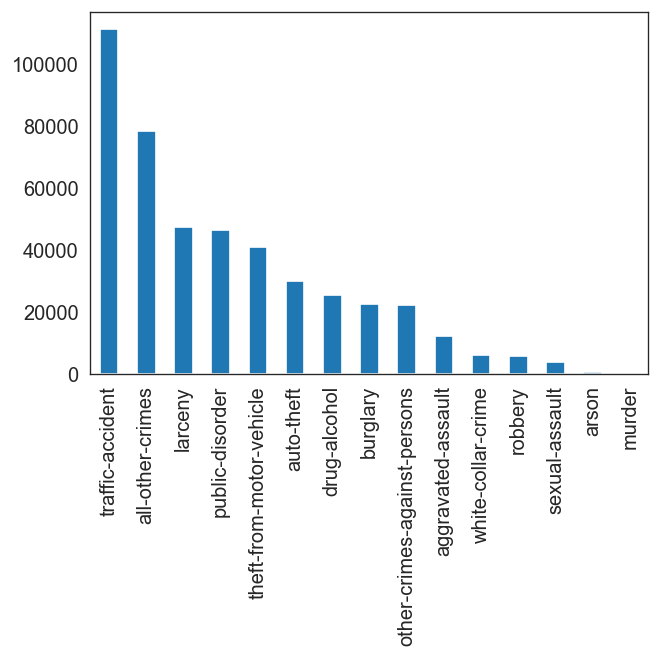

In [40]:
df_crime["OFFENSE_CATEGORY_ID"].value_counts().plot.bar()

Hierin valt op dat het overgrote gedeelte van de incidenten bestaat uit verkeersongelukken. Daarnaast past ook een groot gedeelte van de incidenten niet binnen een algemene categorie. Tevens wordt er weinig moord gepleegd en wordt er weinig brand gesticht.

Volgens [denvergov.org](https://web.archive.org/web/20150218132558/http://www.denvergov.org/denvermaps/documents/citywide/Neighborhoods.pdf) bestaat Denver uit totaal 78 verschillende wijken.

In [41]:
len(df_crime["NEIGHBORHOOD_ID"].unique())

80

Toch bestaat de dataset uit 80 verschillende wijken. Dit valt er verklaren op basis van een naamsverandering (Stapleton naar Central Park) en de NaN-rij.

# Data Preparation

## Select Data
Voor job story twee maken we gebruik van de volgende kolommen uit het bestand “crime.csv”.

-	INCIDENT_ID
-	OFFENSE_CATEGORY_ID
-	FIRST_OCCURRENCE_DATE
-	NEIGHBORHOOD_ID

Om het aantal misdaden te meten per wijk moeten er een aantal kolommen worden geselecteerd. De incidenten worden gemeten met het ‘INCIDENT_ID’. Voor de categorie is gekozen voor de kolomnaam “OFFENSE_CATEGORY_ID”, omdat deze kolom de misdaad verdeeld in een aantal globale categorieën. Voor de datum is er gekozen voor de “FIRST_OCCURRENCE_DATE”, dat is de tijd waarop het incident plaatsvindt. Voor de datum pakken we alle incidenten van 2020.

Het vliegveld word buiten wegen gelaten, omdat het vanzelfsprekend is dat daar de meeste incidenten plaatsvinden. Door het vliegveld bij de wijken weg te laten krijgt de gemeente een goed beeld van de wijken waar de meeste incidenten plaatsvinden.

In [42]:
# 'dia' staat voor 'Denver International Airport'
df_crime = df_crime[df_crime["NEIGHBORHOOD_ID"] != "dia"]

# Alleen de data van 2020
df_crime = df_crime[df_crime["FIRST_OCCURRENCE_DATE"].dt.year == 2020]

Een wijk in Denver genaamd Central Park heette in eerste instantie Stapleton. Door deze naamsverandering wordt er dus naar dezelfde wijk verwezen onder twee verschillende namen. Er is gekozen om alle verwijzingen naar de oude naam (Stapleton) om te zetten naar de nieuwe naam.

Ook is uit de Data Description fase gebleken dat er een enkele rij is waarbij o.a. gegevens over de wijk waar het incident heeft plaatsgevonden mist. Deze rij is dan ook onbruikbaar en zal achterwege worden gelaten.

## Clean data

In [43]:
# Doorvoeren naamsverandering van de wij Stapleton naar Central Park
df_crime["NEIGHBORHOOD_ID"] = df_crime["NEIGHBORHOOD_ID"].replace("stapleton", "central-park")

# Verwijder de rij waarbij o.a. de wijk niet bekend is
df_crime = df_crime.dropna(subset=["NEIGHBORHOOD_ID"])

## Integrate Data

Om een juist beeld te krijgen van de verdeling van de misdaden in Denver, moet er rekening gehouden worden met de hoeveelheid mensen die wonen in een gegeven wijk. Het zou immers logisch zijn dat een wijk met meer inwoners meer incidenten van, bijvoorbeeld, huiselijk geweld heeft.

De Denver crime dataset bevat geen gevens over de hoeveelheid inwoners van een wijk op het moment dat een incident plaatsvond. In dit verslag wordt er alleen gekeken naar de gevens van 2020, dus hiervan hebben wij alleen de populatie nodig.

Helaas was de meest recente data die wij konden vinden afkomstig uit 2010. Om toch enigszins rekening te houden met een groei in populatie is er voor gekozen om een groeifactor te berekenen van de populatie in 2010 ten opzichte van die in 2020. Deze is vervolgens toegepast op de gegevens uit 2010.

In [44]:
# Inlezen van de populatie dataset
df_population = pd.read_csv("census_neighborhood_demographics_2010.csv", dtype={
    "POPULATION_2010": "int64"
})

# Omtoveren van namen naar IDs overeenkomend met de Denver crime dataset
df_population["NEIGHBORHOOD_ID"] = df_population["NBRHD_NAME"].replace({
    "Cory - Merrill": "Cory Merrill",
    "Stapleton": "Central Park",
    "Gateway / Green Valley Ranch": "Gateway Green Valley Ranch",
    "College View / South Platte": "College View South Platte"
}).apply(lambda x: x.lower().replace(" ", "-"))

# De populatie dataset bevat vervelende opmaak die het veranderen tot IDs hindert
df_population["NBRHD_NAME"] = df_population["NBRHD_NAME"].replace({
    "Stapleton": "Central Park"
}).replace("/", "-", regex=True)

# Source: https://worldpopulationreview.com/us-cities/denver-co-population
population_2020 = 738_200
population_2010 = df_population["POPULATION_2010"].sum()
population_growth_factor = population_2020 / population_2010

df_population["POPULATION_2020"] = (df_population["POPULATION_2010"] * population_growth_factor).round()

population_lookup = dict(df_population[["NBRHD_NAME", "POPULATION_2020"]].values)

df_crime = df_crime.merge(df_population[["NEIGHBORHOOD_ID", "NBRHD_NAME"]])
df_crime.rename(columns={
    "NBRHD_NAME": "NEIGHBORHOOD_NAME"
}, inplace=True)

# Modeling

Om voor de gemeente visueel te krijgen hoeveel misdaden per wijk er hebben plaatsgevonden in 2020, wordt er gebruik gemaakt van een choropletenkaart. Hierop is te zien hoe vaak de misdaad voorkomt per duizend inwoners voor een gegeven wijk. Ook is er voor iedere type misdaad een staafdiagram gemaakt met daarin de top 10 wijken per type misdaad.

In [45]:
# Dit zijn de grenzen van de wijken
with open("denver-statistical-neighborhoods.geojson") as geo:
    neighborhoods = json.load(geo)

for name, group in df_crime.groupby("OFFENSE_CATEGORY_ID"):
    crimes_per_neighborhood = group.groupby("NEIGHBORHOOD_NAME")\
        ["INCIDENT_ID"].count()\
        .reset_index()

    crimes_per_neighborhood["POPULATION"] = crimes_per_neighborhood["NEIGHBORHOOD_NAME"].apply(lambda x: population_lookup[x] / 1000)

    crimes_per_neighborhood["OCCURRENCE"] = crimes_per_neighborhood["INCIDENT_ID"] / crimes_per_neighborhood["POPULATION"]

    # Lege map met Denver als locatie
    m = folium.Map(location=[39.7392, -104.9903], zoom_start=11)

    # Toevoegen van de gekleurde blokjes
    folium.Choropleth(
        geo_data=neighborhoods,
        name="choropleth",
        data=crimes_per_neighborhood,
        columns=["NEIGHBORHOOD_NAME", "OCCURRENCE"],
        key_on="properties.nbhd_name",
        fill_color="RdPu",
        fill_opacity=0.7,
        line_opacity=0.2,
        nan_fill_opacity=0.2,
        legend_name="Hoeveelheid {} incidenten per duizend inwoners (1000x)".format(name),
    ).add_to(m)

    # Dit is de style van de overlay zelf
    style_function = lambda x: {
        'fillOpacity': 0.0,
        'weight': 0.0
    }

    # Dit is de style als je er met je muis overheen gaat
    highlight_function = lambda x: {
        'fillColor': '#000000',
        'color':'#000000',
        'fillOpacity': 0.50,
        'weight': 0.1
    }

    # Dit zorgt ervoor dat je de wijken kan uitlezen
    overlay = folium.features.GeoJson(neighborhoods,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['nbhd_name'],
            aliases=['Neighborhood: '],
            style="background: white; color: #1a1a1a;"
        )
    )
    m.add_child(overlay)
    m.keep_in_front(overlay)
    overlay.add_to(m)

    m.save("models/" + name + ".html")

    crimes_per_neighborhood = crimes_per_neighborhood.nlargest(10, "OCCURRENCE")
    g = sns.barplot(
        data=crimes_per_neighborhood,
        x="NEIGHBORHOOD_NAME",
        y="OCCURRENCE"
    )
    g.set(
        title="Hoeveelheid " + name.replace("-", " ") + " incidenten",
        xlabel="Wijk",
        ylabel="Misdaden per duizend inwoners (1000x)"
    )
    plt.xticks(rotation=90)
    g.figure.savefig("models/" + name + ".png", bbox_inches='tight')
    plt.close()

# Evaluation

In dit hoofdstuk worden alleen het type misdaden behandeld waarin zich een interessant patroon voortdoet.

## Autodiefstal

Op de kaart van autodiefstal valt een patroon te zien: de wijken waardoor de snelwegen lopen is het aantal gerapporteerde autodiefstallen hoger dan in andere wijken.

De kaart zelf zegt weinig tot niets over waar de auto's worden gestolen. Het is dan ook niet mogelijk om te zien waar de auto's worden gestolen, dus deze kaart kan niet preventief worden ingezet.

Door meer toezicht op de snelwegen te hebben, kunnen autodiefstallen beter worden gesignaleerd.

## Drugs- en alcoholincidenten

In het midden van Denver valt er een cluster te zien bestaande uit Civic Center, Auraria en CBD (Central Business District) waar de hoeveelheid drugs- en alcoholincidenten relatief hoog is, maar dit valt makkelijk toe te wijden aan de relatief lage populatie van Civic Center (~2000) en Auraria (~900). Daarnaast is het Central Business District hoogstwaarschijnlijk een populair uitgaansgebied, waardoor het logisch is dat dit zorgt voor een hogere concentratie van dit type misdaad.

De enige uitzondering hierop is Overland met ongeveer drieduizend inwoners. Dit is namelijk een buitenwijk en kan daarom niet worden verklaard op dezelfde manier als o.a. Civic Center.

Het zou dus kunnen lonen op meer aandacht aan deze wijk te besteden op het gebied drugsmisbruik.

## Brandstichting en moord

Doordat brandstichting en moord zich weinig voortdoen, is het eigenlijk niet mogelijk om hier conclusies aan te verbinden. Als er bijvoorbeeld twee moorden worden gepleegd in een wijk met relatief weinig inwoners, zal deze wijk eruit springen ondanks dat het toeval zou kunnen zijn.

Om van deze type misdaden een beter beeld te krijgen, zou het beter zijn om te kijken naar hoe vaak deze voorkomen over de jaren heen. Als dit aantal consistent hoog is, kan er pas een conclusie worden getrokken.